<a href="https://colab.research.google.com/github/Gruzver/AR_tester/blob/main/Tarea_Laboratorio7_TemasA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **TAREA-II. CIFAR-100**
A continuación se solicita realizar la comparación del comportamiento de las dos (02) técnicas revisadas y comparar resultados usando el dataset CIFAR-100. Pueden probar distintas arquitecturas de CNN y Red Neuronal

***(5 Puntos)***

1.   Lectura del Dataset - revisar dimensiones
2.   Tratamiento necesario del Dataset
3.   Modelo de Red Neuronal
4.   Modelo de CNN
5.   Comparación de metricas, no es necesario graficar la matriz de confusión y plantear posibles mejoras al modelo

NOTA ADICIONAL:
-Para la corrección de esta tarea se valorá más la interpretación de las metricas y comparación de modelos y como mejorarías el modelo

In [70]:
#Se importa la clase para que puedan cargar el dataset
from tensorflow.keras.datasets import cifar100

In [71]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPool2D, Flatten

In [72]:
#Mostramos el entrenamiento de la red Neuronal
def history_analisis(history):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))

  ax1.plot(history.history['accuracy'], label='accuracy')
  ax1.plot(history.history['val_accuracy'], label = 'val_accuracy')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Accuracy')
  ax1.set_ylim([0, 1])
  ax1.legend(loc='lower right');

  ax2.plot(history.history['loss'], label='loss')
  ax2.plot(history.history['val_loss'], label = 'val_loss')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Loss')
  ax2.set_ylim([0, 10])
  ax2.legend(loc='lower right');

In [4]:
#Definición de funcion para el calculo de metricas multi-clase
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def calculo_metricas(CM, labels):
    categoria = []
    TruPos = []
    FalPos = []
    FalNeg = []
    TruNeg = []
    acc = []
    prec = []
    recall = []
    f1 = []

    total = np.sum(CM)

    for i in range(len(labels)):
        TP = CM[i][i]
        FP = sum(CM[:, i]) - TP
        FN = sum(CM[i, :]) - TP
        TN = total - TP - FN - FP
        a = (TP + TN) / (TP + TN + FN + FP)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        f = 2 * (r * p) / (r + p)

        categoria.append(labels[i])
        TruPos.append(TP)
        FalPos.append(FP)
        TruNeg.append(TN)
        acc.append(a)
        prec.append(p)
        recall.append(r)
        f1.append(f)

    metricas = pd.DataFrame({
        'Métrica': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
        'Máximo': [max(acc), max(prec), max(recall), max(f1)],
        'Mínimo': [min(acc), min(prec), min(recall), min(f1)],
        'Promedio': [np.mean(acc), np.mean(prec), np.mean(recall), np.mean(f1)]
    })

    return metricas

def graf_confusion_matrix(CM, clases, add_text):
    fig, ax = plt.subplots(figsize=(8, 8))  # Ajusta el tamaño de la figura
    sns.heatmap(CM, annot=False, xticklabels=False, yticklabels=False, ax=ax, cmap='Blues')
    ax.set_title('Matriz de confusión ' + add_text)
    ax.set_xlabel('Valores Predecidos')
    ax.set_ylabel('Valores Verdaderos')
    plt.show()

In [73]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

In [74]:

#Convertir a escala de grises
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = np.mean(X_train, axis=3, keepdims=True)
X_test = np.mean(X_test, axis=3, keepdims=True)

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (50000, 32, 32, 1)
y_train shape (50000, 1)
X_test shape (10000, 32, 32, 1)
y_test shape (10000, 1)


In [75]:
#verificar cuantas clases tiene el y_train
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

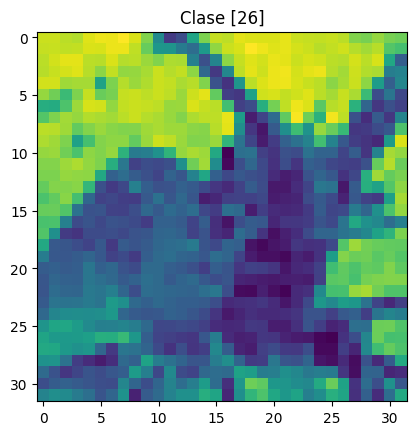

In [76]:
#Mostramos una imagen random del dataset
num = random.randint(0, len(X_train))
plt.imshow(X_train[num], interpolation='none')
plt.title("Clase {}".format(y_train[num]));

**1. Modelo con Red Feedforward **

In [77]:
#tratamiento de datos
from tensorflow.keras.utils import to_categorical

X_train_flat = X_train.reshape(-1, 32*32)
X_test_flat = X_test.reshape(-1, 32*32)

y_train = to_categorical(y_train, 100)
y_test = to_categorical(y_test, 100)

In [78]:
from tensorflow import keras
from tensorflow.keras import layers

In [84]:
model_NN = keras.Sequential()
model_NN.add(Dense(256, input_dim=X_train_flat.shape[1], activation='relu'))
model_NN.add(layers.Dense(128, activation='relu'))
model_NN.add(layers.Dense(64, activation='relu'))
model_NN.add(layers.Dense(100, activation='softmax'))

model_NN.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 256)               262400    
                                                                 
 dense_35 (Dense)            (None, 128)               32896     
                                                                 
 dense_36 (Dense)            (None, 64)                8256      
                                                                 
 dense_37 (Dense)            (None, 100)               6500      
                                                                 
Total params: 310052 (1.18 MB)
Trainable params: 310052 (1.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
782/782 [==============================] - 4s 4ms/step - loss: 4.4291 - accuracy: 0.0318 - val_loss: 4.2674 - val_accuracy: 0.0571
Epoch 2/50
782/782 [==============================] - 3s 4ms/step - loss: 4.1943 - accuracy: 0.0667 - val_loss: 4.1415 - val_accuracy: 0.0766
Epoch 3/50
782/782 [==============================] - 3s 4ms/step - loss: 4.0652 - accuracy: 0.0860 - val_loss: 4.0479 - val_accuracy: 0.0944
Epoch 4/50
782/782 [==============================] - 4s 5ms/step - loss: 3.9935 - accuracy: 0.0988 - val_loss: 4.0340 - val_accuracy: 0.0952
Epoch 5/50
782/782 [==============================] - 3s 4ms/step - loss: 3.9311 - accuracy: 0.1097 - val_loss: 3.9665 - val_accuracy: 0.1129
Epoch 6/50
782/782 [==============================] - 3s 4ms/step - loss: 3.8769 - accuracy: 0.1192 - val_loss: 3.9171 - val_accuracy: 0.1174
Epoch 7/50
782/782 [==============================] - 3s 4ms/step - loss: 3.8369 - accuracy: 0.1252 - val_loss: 3.9024 - val_accuracy: 0.1248
Epoch 

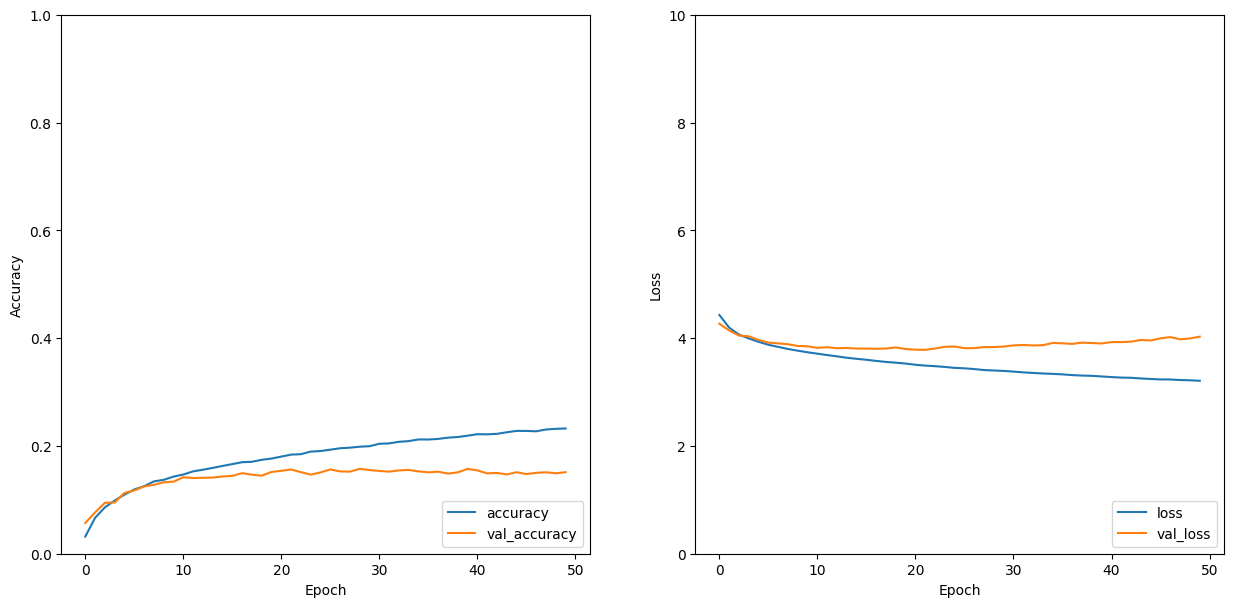

In [85]:
from tensorflow.keras.optimizers import Adam

model_NN.compile(optimizer="Adam", loss='categorical_crossentropy',  metrics=['accuracy'])
history_NN = model_NN.fit(X_train_flat, y_train, epochs=50, batch_size=64, validation_data=(X_test_flat, y_test), verbose=1)
history_analisis(history_NN)

313/313 [==============================] - 1s 2ms/step


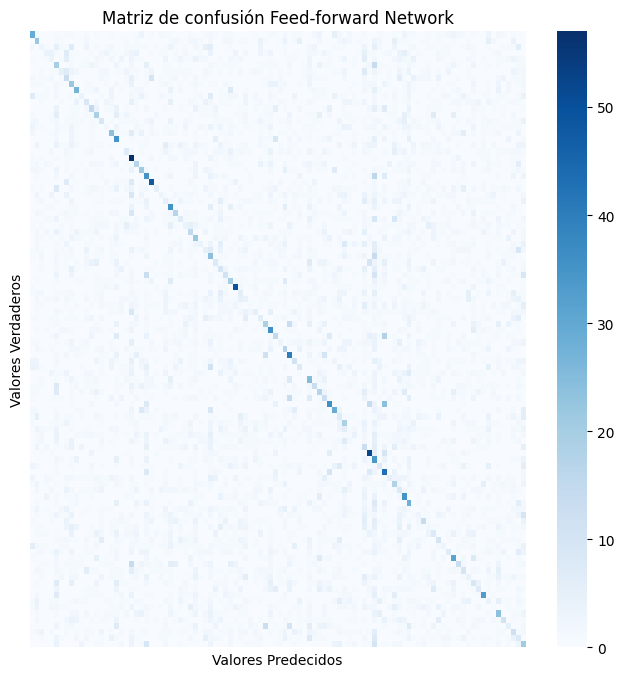

In [86]:
clases_NN = [str(i) for i in range(100)]

y_pred = model_NN.predict(X_test_flat)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

CM_NN = confusion_matrix(y_test_classes, y_pred_classes) #, normalize='true'
graf_confusion_matrix(CM_NN, clases_NN, 'Feed-forward Network')

In [87]:
calculo_metricas(CM_NN, clases_NN)

<ipython-input-4-49590a811503>:28: RuntimeWarning: invalid value encountered in scalar divide
  f = 2 * (r * p) / (r + p)


,Métrica,Máximo,Mínimo,Promedio
0,Accuracy,0.988900,0.960400,0.983026
1,Precision,0.448598,0.000000,0.139400
2,Recall,0.570000,0.000000,0.151300
3,F1-Score,0.463768,0.012048,NaN


**2. Modelo con CNN **

In [64]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

In [65]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

model_CNN = keras.Sequential()
model_CNN.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_CNN.add(MaxPool2D((2, 2)))

model_CNN.add(Conv2D(128, (3, 3), activation='relu'))
model_CNN.add(MaxPool2D((2, 2)))
model_CNN.add(Dropout(0.4))
model_CNN.add(Conv2D(256, (3, 3), activation='relu'))
model_CNN.add(Dropout(0.2))
model_CNN.add(MaxPool2D((2, 2)))
model_CNN.add(Flatten())
model_CNN.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model_CNN.add(Dense(100, activation='softmax'))

model_CNN.summary()


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 15, 15, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_35 (Conv2D)          (None, 13, 13, 128)       73856     
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 6, 6, 128)         0         
 ng2D)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 6, 6, 128)         0         
                                                                 
 conv2d_36 (Conv2D)          (None, 4, 4, 256)       

In [66]:
model_CNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_CNN = model_CNN.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
782/782 [==============================] - 7s 7ms/step - loss: 5.3093 - accuracy: 0.0274 - val_loss: 4.7744 - val_accuracy: 0.0378
Epoch 2/50
782/782 [==============================] - 6s 7ms/step - loss: 4.4875 - accuracy: 0.0731 - val_loss: 4.3282 - val_accuracy: 0.1032
Epoch 3/50
782/782 [==============================] - 5s 7ms/step - loss: 4.0444 - accuracy: 0.1318 - val_loss: 3.8194 - val_accuracy: 0.1816
Epoch 4/50
782/782 [==============================] - 6s 7ms/step - loss: 3.6335 - accuracy: 0.1957 - val_loss: 3.4693 - val_accuracy: 0.2504
Epoch 5/50
782/782 [==============================] - 6s 7ms/step - loss: 3.3501 - accuracy: 0.2420 - val_loss: 3.2932 - val_accuracy: 0.2662
Epoch 6/50
782/782 [==============================] - 5s 7ms/step - loss: 3.1638 - accuracy: 0.2752 - val_loss: 3.1946 - val_accuracy: 0.2907
Epoch 7/50
782/782 [==============================] - 6s 8ms/step - loss: 3.0508 - accuracy: 0.2951 - val_loss: 3.0900 - val_accuracy: 0.3116
Epoch 

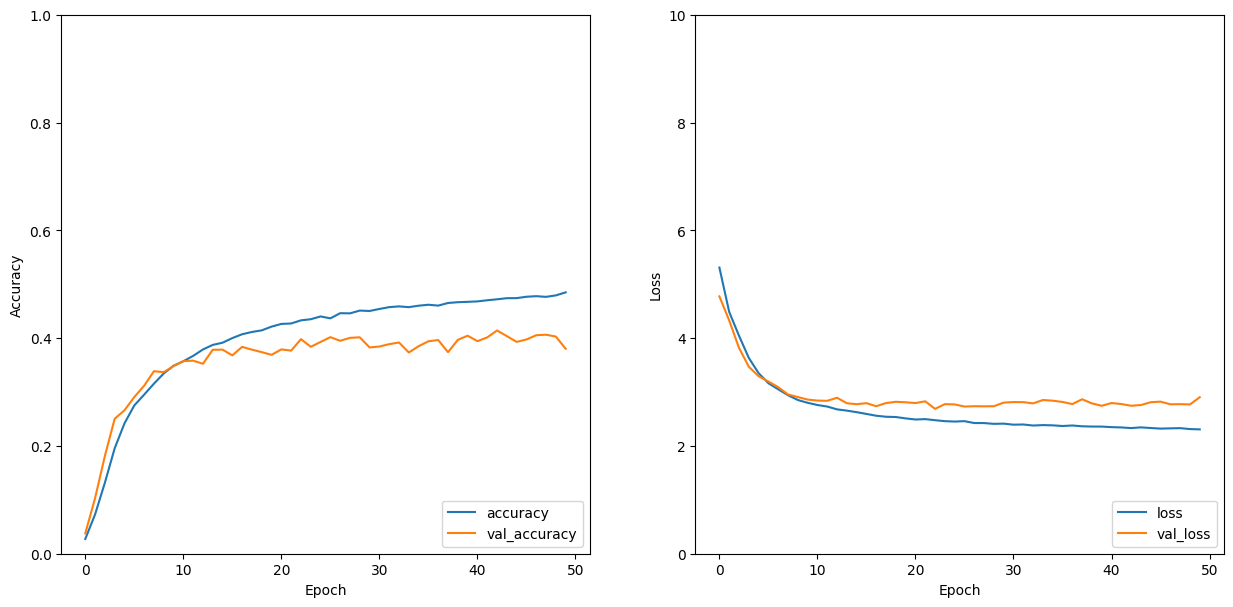

In [67]:
history_analisis(history_CNN)

313/313 [==============================] - 1s 2ms/step


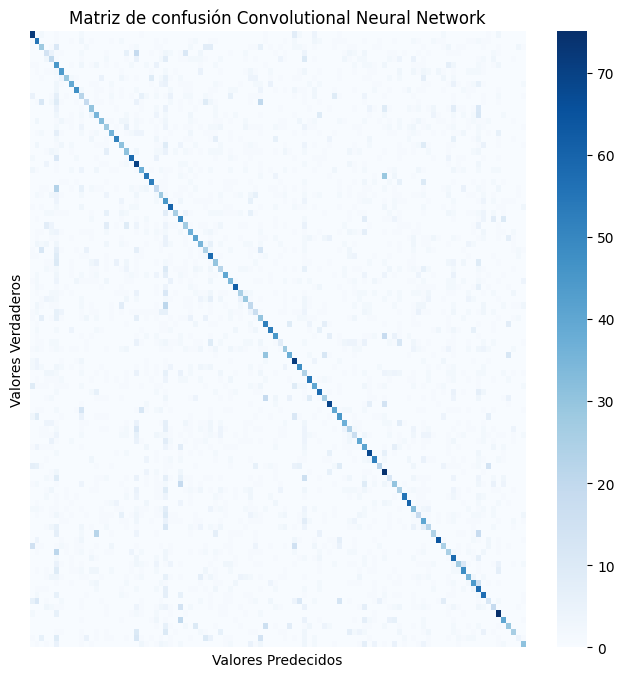

In [68]:
clases_CNN = [str(i) for i in range(100)]

y_pred5 = model_CNN.predict(X_test)
y_pred6 = np.argmax(y_pred5, axis=1)

CM_CNN = confusion_matrix(y_test, y_pred6) #, normalize='true'

graf_confusion_matrix(CM_CNN, clases_CNN, 'Convolutional Neural Network')

In [69]:
calculo_metricas(CM_CNN, clases_CNN)

,Métrica,Máximo,Mínimo,Promedio
0,Accuracy,0.994800,0.963400,0.987606
1,Precision,0.808824,0.123077,0.416268
2,Recall,0.750000,0.040000,0.380300
3,F1-Score,0.711111,0.068376,0.381428


Se realizaron dos modelos; ANN y CNN para la base da datos de CIFAR-100, en el primer modelo para 50 épocas se obtuvo un accuracy: 0.2324 y val_accuracy: 0.1513, muy inferior para considerarse adecuado, incluso luego de realizar técnicas de prepocesamiento como normalizado y escala de grises, del gráfico de entrenamiento se observa como el modelo empieza a estancarse en la época 40 mientras que mucho antes ya se empieza a generar overfitting. Para el modelo con CNN se obtiene un valor de accuracy: 0.4849 y val_accuracy: 0.3803, para este caso se mantienen las 3 capas de color y en la estructura se incuye dropout y regularización para evitar el overfitting generado en iteraciones previas. Aunque el modelo es superior, aun es posible obtener mejores modelos.
En Reed Feedforward podríamos aumentar la cantidad de capas junto con dropout y cantidad de épocas, a pesar de ello, por la misma red, no se conseguirían grandes resultados.
Para el caso de CNN, podríamos aumentar la cantidad de epocas, en un punto se generaría overfitting, para ello se debe disminuir el learning rate, disminuir el bach size, iterarar en los valores de dropout, incluso agregar una capa más y ajustar la regularización, reducir el modelo a una escala de grises podría miinimizar la carga de entrenamiento aunque limitar los resultados.